# **PROJECT OBJECTIVE**

Analyze how trading behavior (profitability, risk, volume, and emotion) aligns with market sentiment (Fear & Greed) and identify hidden regimes that enable smarter trading strategies.

# **Import Libraries & Setup**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# **Load Datasets**

In [11]:
fear = pd.read_csv("/content/drive/MyDrive/fear_greed_index.csv")
trades = pd.read_csv("/content/drive/MyDrive/historical_data.csv")


# **Initial Data Inspection**

In [12]:
fear.head()
trades.head()
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

# **Timestamp Cleaning & Date Alignment**

In [13]:

trades = pd.read_csv("/content/drive/MyDrive/historical_data.csv")


In [15]:
trades['Timestamp'].head(10)


,Timestamp
0,1.730000e+12
1,1.730000e+12
2,1.730000e+12
3,1.730000e+12
4,1.730000e+12
5,1.730000e+12
6,1.730000e+12
7,1.730000e+12
8,1.730000e+12
9,1.730000e+12


In [16]:
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')


In [17]:
trades['date'] = trades['Timestamp'].dt.date


In [18]:
trades[['Timestamp','date']].head()


,Timestamp,date
0,2024-10-27 03:33:20,2024-10-27
1,2024-10-27 03:33:20,2024-10-27
2,2024-10-27 03:33:20,2024-10-27
3,2024-10-27 03:33:20,2024-10-27
4,2024-10-27 03:33:20,2024-10-27


In [19]:
fear['date'] = pd.to_datetime(fear['date']).dt.date
fear.rename(columns={'classification':'Classification'}, inplace=True)


# **Merge Trade Data with Market Sentiment**

In [20]:
merged = trades.merge(
    fear[['date','Classification']],
    on='date',
    how='left'
)


In [21]:
merged['Classification'].isna().value_counts()


,count
Classification,
False,184263
True,26961


# **Handle Missing Sentiment Values**

In [22]:
merged_clean = merged.dropna(subset=['Classification'])


In [23]:
merged_clean['is_win'] = merged_clean['Closed PnL'] > 0
merged_clean['abs_pnl'] = merged_clean['Closed PnL'].abs()


/tmp/ipython-input-2536340394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_clean['is_win'] = merged_clean['Closed PnL'] > 0
/tmp/ipython-input-2536340394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_clean['abs_pnl'] = merged_clean['Closed PnL'].abs()


# **Feature Engineering**

In [24]:
merged_clean = merged.dropna(subset=['Classification']).copy()

merged_clean['is_win'] = merged_clean['Closed PnL'] > 0
merged_clean['abs_pnl'] = merged_clean['Closed PnL'].abs()


# **Aggregate Metrics by Market Regime**

In [25]:
summary = merged_clean.groupby('Classification').agg({
    'Closed PnL': ['mean', 'std'],
    'Size USD': 'mean',
    'Start Position': 'mean',
    'is_win': 'mean',
    'abs_pnl': 'mean'
}).reset_index()

summary.columns = [
    'Sentiment',
    'Avg_PnL',
    'PnL_Volatility',
    'Avg_Size_USD',
    'Avg_Risk',
    'Win_Rate',
    'Avg_Abs_PnL'
]

summary


,Sentiment,Avg_PnL,PnL_Volatility,Avg_Size_USD,Avg_Risk,Win_Rate,Avg_Abs_PnL
0,Extreme Greed,25.418772,306.166937,5660.265764,70307.280908,0.490089,48.333821
1,Fear,50.047622,909.121796,5259.977837,13170.980222,0.415146,70.186245
2,Greed,87.894859,1148.343968,3182.883845,19741.005986,0.446471,116.121900
3,Neutral,22.229713,633.704815,3058.848110,5895.819177,0.317182,68.343278


# **Rename Columns for Interpretability**

In [26]:
summary = summary.rename(columns={
    "Avg_PnL": "Average Profit per Trade (USD)",
    "PnL_Volatility": "Profit Volatility (Risk)",
    "Avg_Size_USD": "Average Trade Size (USD)",
    "Avg_Risk": "Average Exposure",
    "Win_Rate": "Winning Trade %",
    "Avg_Abs_PnL": "Emotional Intensity (Avg |PnL|)"
})

summary


,Sentiment,Average Profit per Trade (USD),Profit Volatility (Risk),Average Trade Size (USD),Average Exposure,Winning Trade %,Emotional Intensity (Avg |PnL|)
0,Extreme Greed,25.418772,306.166937,5660.265764,70307.280908,0.490089,48.333821
1,Fear,50.047622,909.121796,5259.977837,13170.980222,0.415146,70.186245
2,Greed,87.894859,1148.343968,3182.883845,19741.005986,0.446471,116.121900
3,Neutral,22.229713,633.704815,3058.848110,5895.819177,0.317182,68.343278


In [27]:
!mkdir -p outputs


# **Profitability Across Market Sentiments**

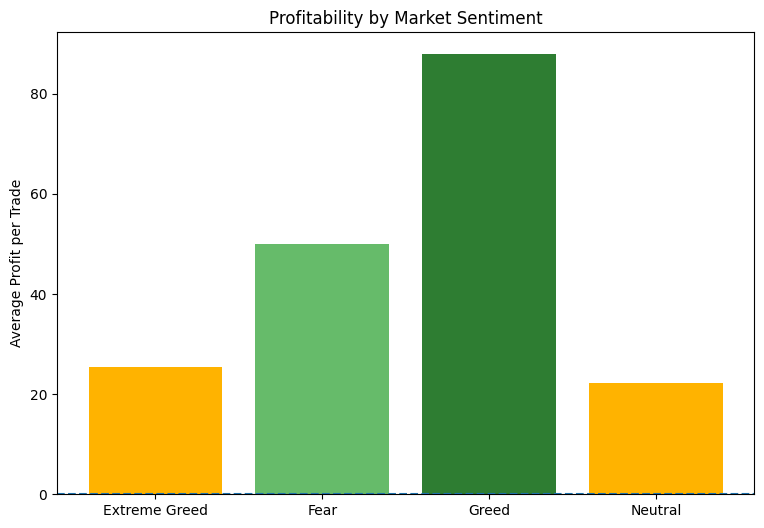

In [28]:
profit_colors = []

for val in summary["Average Profit per Trade (USD)"]:
    if val > 60:
        profit_colors.append("#2E7D32")   # strong green
    elif val > 30:
        profit_colors.append("#66BB6A")   # light green
    elif val > 0:
        profit_colors.append("#FFB300")   # warning
    else:
        profit_colors.append("#D32F2F")   # loss

plt.figure(figsize=(9,6))
plt.bar(
    summary["Sentiment"],
    summary["Average Profit per Trade (USD)"],
    color=profit_colors
)

plt.axhline(0, linestyle="--")
plt.title("Profitability by Market Sentiment")
plt.ylabel("Average Profit per Trade")

plt.savefig("outputs/profit_by_sentiment.png")
plt.show()




# **Risk Exposure Across Market Sentiments**

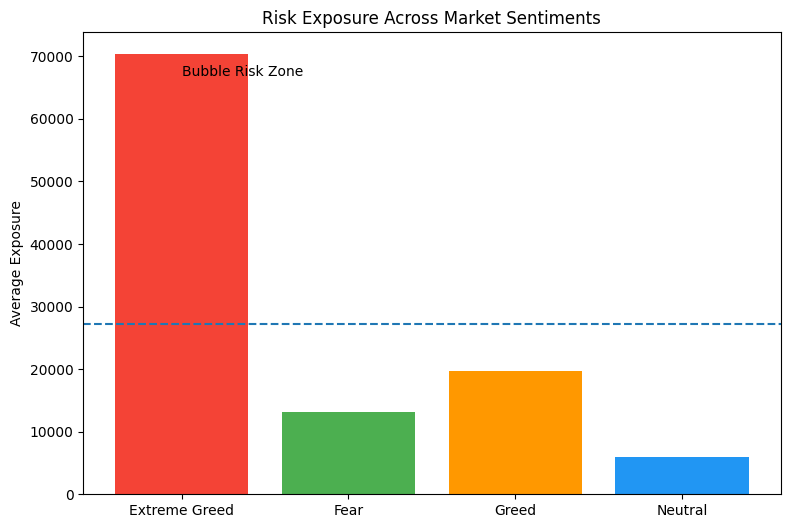

In [29]:
import numpy as np

plt.figure(figsize=(9,6))

colors = ["#F44336", "#4CAF50","#FF9800",  "#2196F3"]
# Greed, Fear, Extreme Greed, Neutral style mapping

plt.bar(
    summary["Sentiment"],
    summary["Average Exposure"],
    color=colors
)

plt.axhline(summary["Average Exposure"].mean(), linestyle="--")
plt.title("Risk Exposure Across Market Sentiments")
plt.ylabel("Average Exposure")

plt.text("Extreme Greed", summary["Average Exposure"].max()*0.95, "Bubble Risk Zone", color="black")

plt.savefig("outputs/risk_by_sentiment.png")
plt.show()



# **Risk–Reward Regime Map**

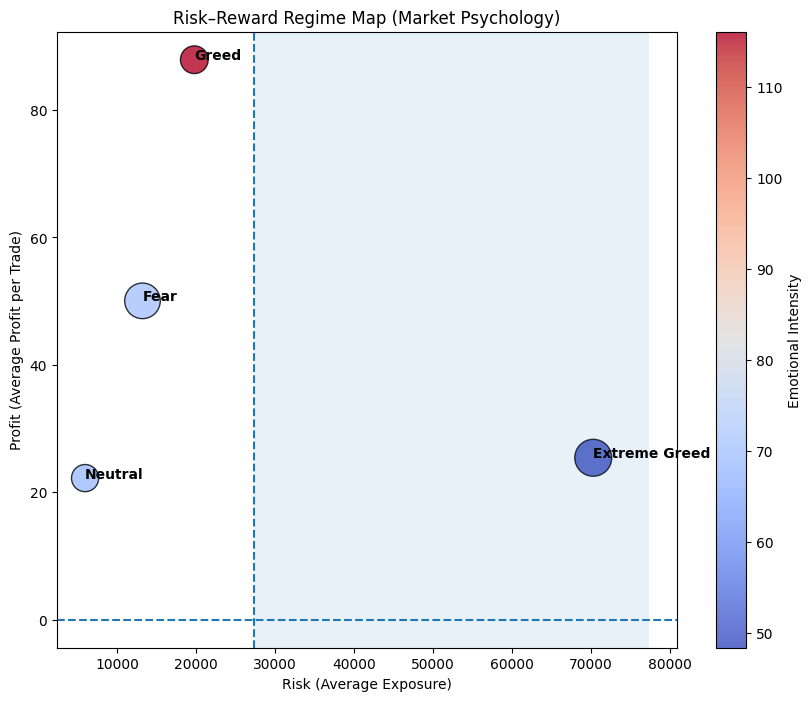

In [30]:
plt.figure(figsize=(10,8))

# Bubble scatter
plt.scatter(
    summary["Average Exposure"],
    summary["Average Profit per Trade (USD)"],
    s=summary["Average Trade Size (USD)"] / 8,
    c=summary["Emotional Intensity (Avg |PnL|)"],  # color by emotion
    cmap="coolwarm",
    alpha=0.8,
    edgecolors="black"
)

# Add labels
for i, txt in enumerate(summary["Sentiment"]):
    plt.annotate(
        txt,
        (summary["Average Exposure"][i], summary["Average Profit per Trade (USD)"][i]),
        fontsize=10,
        weight="bold"
    )

# Add reference lines
plt.axhline(0, linestyle="--")   # profit vs loss
plt.axvline(summary["Average Exposure"].mean(), linestyle="--")  # normal risk

# Shaded danger zone
plt.axvspan(summary["Average Exposure"].mean(),
            summary["Average Exposure"].max()*1.1,
            alpha=0.1)

plt.colorbar(label="Emotional Intensity")

plt.xlabel("Risk (Average Exposure)")
plt.ylabel("Profit (Average Profit per Trade)")
plt.title("Risk–Reward Regime Map (Market Psychology)")

plt.savefig("outputs/risk_vs_profit_regime.png")
plt.show()


# **Market Psychology Heatmap**

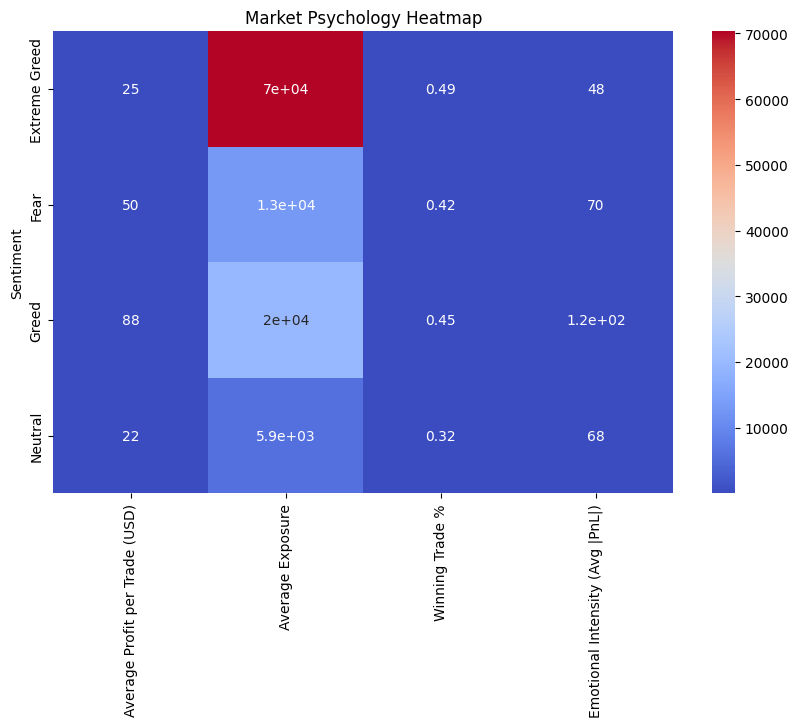

In [31]:
import seaborn as sns

heatmap_data = summary.set_index("Sentiment")[[
    "Average Profit per Trade (USD)",
    "Average Exposure",
    "Winning Trade %",
    "Emotional Intensity (Avg |PnL|)"
]]

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.title("Market Psychology Heatmap")
plt.savefig("outputs/market_psychology_heatmap.png")
plt.show()


# **Risk Saturation: Does Higher Exposure Lead to Higher Returns?**

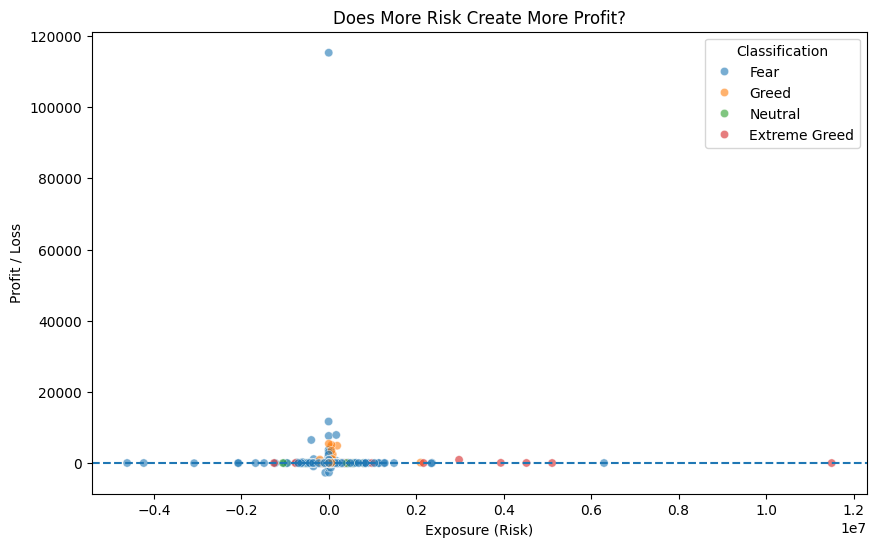

In [32]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=merged_clean.sample(3000),
    x="Start Position",
    y="Closed PnL",
    hue="Classification",
    alpha=0.6
)

plt.axhline(0, linestyle="--")
plt.title("Does More Risk Create More Profit?")
plt.xlabel("Exposure (Risk)")
plt.ylabel("Profit / Loss")
plt.savefig("outputs/risk_saturation.png")
plt.show()


# **Trading Volume Regimes (Log Scale)**

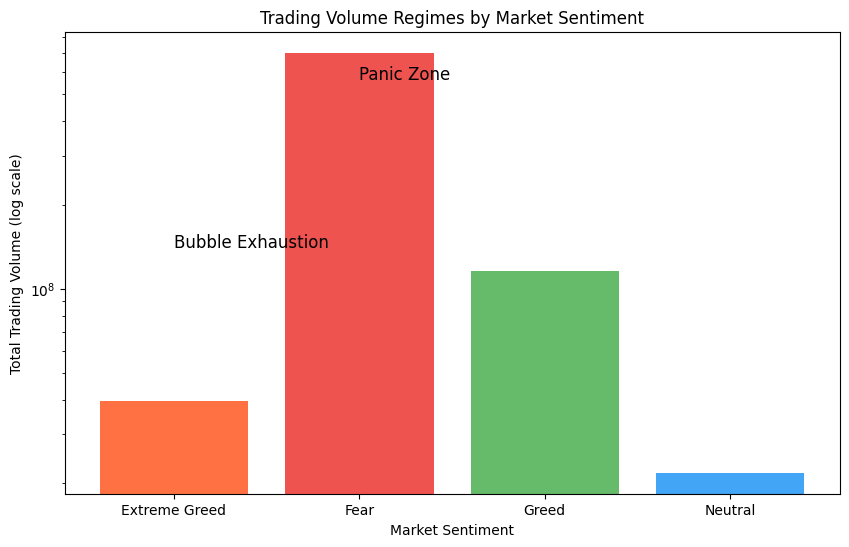

In [33]:
plt.figure(figsize=(10,6))

# Emotion-based colors
colors = ["#FF7043", "#EF5350", "#66BB6A", "#42A5F5"]
# Extreme Greed, Fear, Greed, Neutral

volume_by_sentiment = merged_clean.groupby("Classification")["Size USD"].sum().reset_index()

plt.bar(
    volume_by_sentiment["Classification"],
    volume_by_sentiment["Size USD"],
    color=colors
)

plt.yscale("log")  # show panic spikes clearly
plt.title("Trading Volume Regimes by Market Sentiment")
plt.ylabel("Total Trading Volume (log scale)")
plt.xlabel("Market Sentiment")

# Add annotations
plt.text("Fear", volume_by_sentiment["Size USD"].max()*0.8, "Panic Zone", color="black", fontsize=12)
plt.text("Extreme Greed", volume_by_sentiment["Size USD"].max()*0.2, "Bubble Exhaustion", color="black", fontsize=12)

plt.savefig("outputs/volume_regimes.png")
plt.show()



# **Market Regime Dashboard**

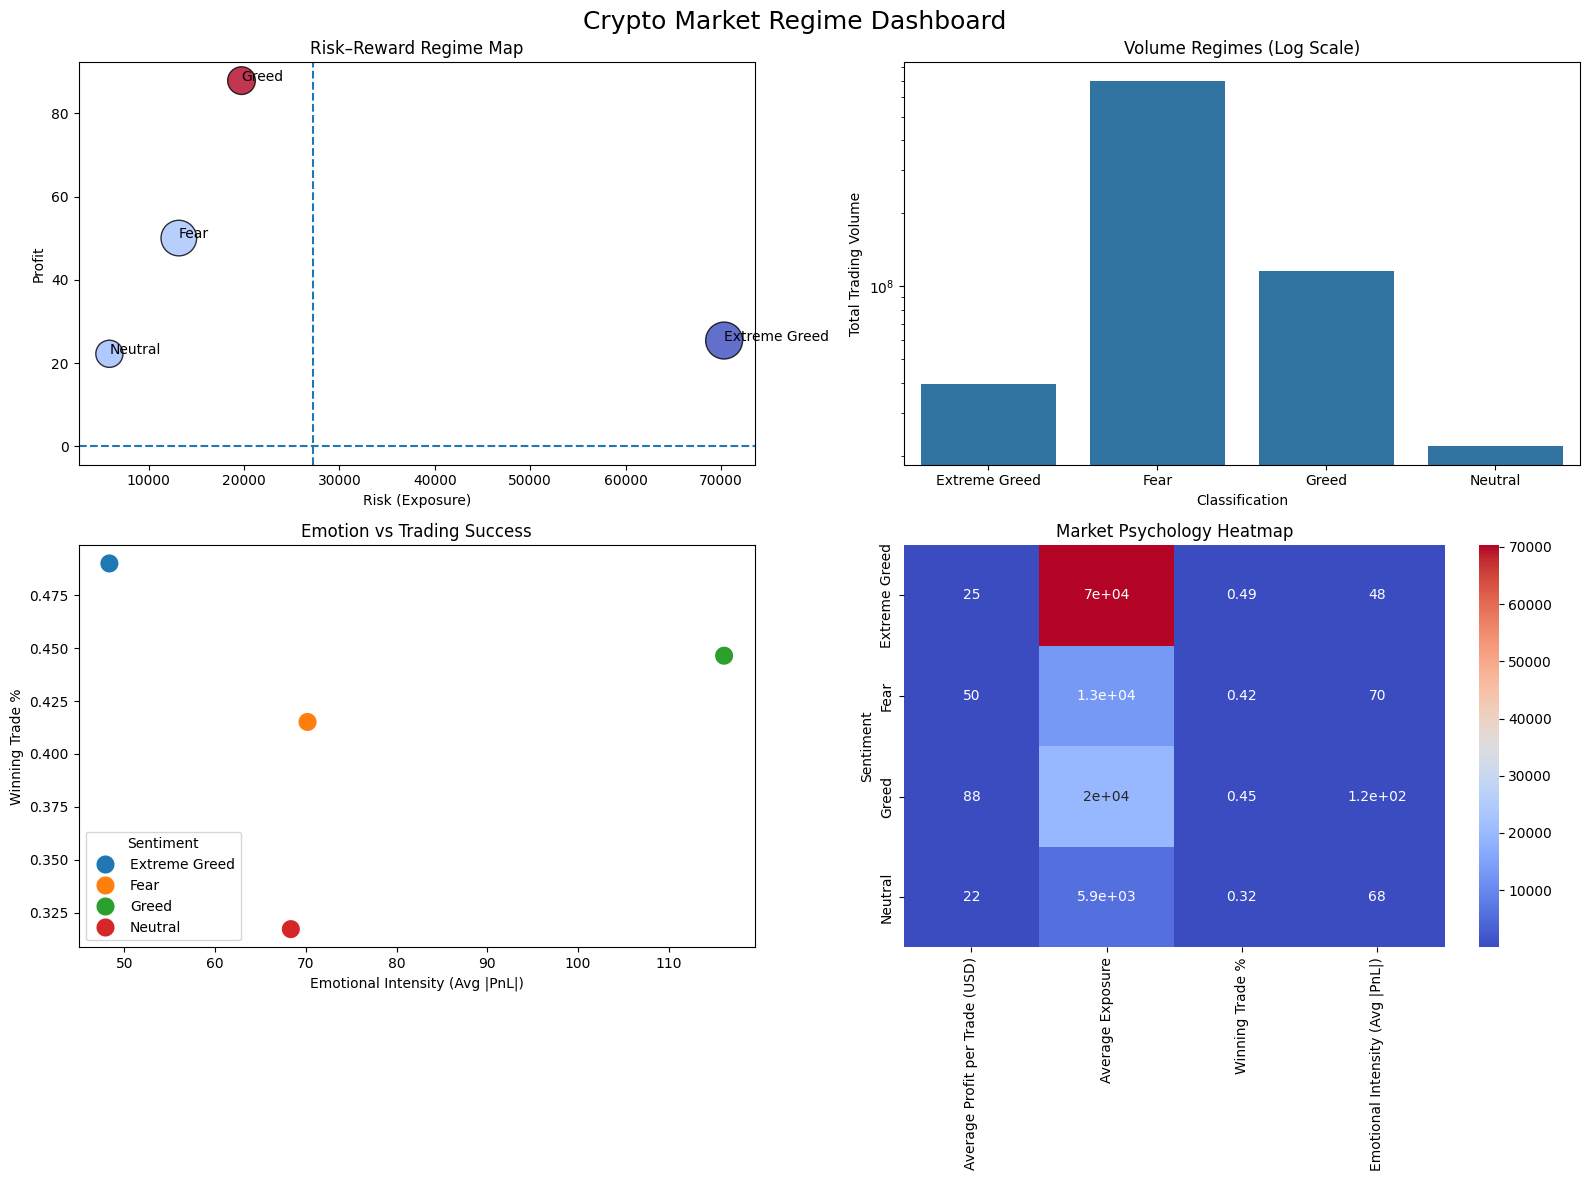

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize=(16,12))


# 1 Risk vs Profit Regime

ax1 = plt.subplot(2,2,1)

scatter = ax1.scatter(
    summary["Average Exposure"],
    summary["Average Profit per Trade (USD)"],
    s=summary["Average Trade Size (USD)"] / 8,
    c=summary["Emotional Intensity (Avg |PnL|)"],
    cmap="coolwarm",
    edgecolors="black",
    alpha=0.8
)

for i, txt in enumerate(summary["Sentiment"]):
    ax1.annotate(txt, (
        summary["Average Exposure"][i],
        summary["Average Profit per Trade (USD)"][i]
    ))

ax1.axhline(0, linestyle="--")
ax1.axvline(summary["Average Exposure"].mean(), linestyle="--")
ax1.set_title("Risk–Reward Regime Map")
ax1.set_xlabel("Risk (Exposure)")
ax1.set_ylabel("Profit")


# 2 Volume Regimes

ax2 = plt.subplot(2,2,2)

volume_by_sentiment = merged_clean.groupby("Classification")["Size USD"].sum().reset_index()

sns.barplot(
    data=volume_by_sentiment,
    x="Classification",
    y="Size USD",
    ax=ax2
)

ax2.set_yscale("log")
ax2.set_title("Volume Regimes (Log Scale)")
ax2.set_ylabel("Total Trading Volume")


# 3 Emotion vs Win Rate

ax3 = plt.subplot(2,2,3)

sns.scatterplot(
    data=summary,
    x="Emotional Intensity (Avg |PnL|)",
    y="Winning Trade %",
    hue="Sentiment",
    s=200,
    ax=ax3
)

ax3.set_title("Emotion vs Trading Success")


# 4 Market Psychology Heatmap

ax4 = plt.subplot(2,2,4)

heatmap_data = summary.set_index("Sentiment")[[
    "Average Profit per Trade (USD)",
    "Average Exposure",
    "Winning Trade %",
    "Emotional Intensity (Avg |PnL|)"
]]

sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", ax=ax4)
ax4.set_title("Market Psychology Heatmap")

plt.suptitle("Crypto Market Regime Dashboard", fontsize=18)
plt.tight_layout()
plt.savefig("outputs/market_regime_dashboard.png")
plt.show()
